# RF & GBDT On Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


### Objective
* To classify the positive and negative reviews.

###  How to classify?
* By applying vectorization techniques such as BOW, TF-IDF ,Avg W2V , Tf-Idf weighted W2V. 
* Column used to check the Acuracy will be Score.
  - Positive review (rating 4-5)
  - Negative review (rating 1-2)

## Loading Data

In [1]:
%matplotlib inline
import warnings as wr
wr.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

con = sqlite3.connect('database.sqlite') #building connnection with database
review_data = pd.read_sql_query('''select * from Reviews where Score != 3''',con)#importing data from database

#function to replace rating with 1(+ve) or 0(-ve)
def Replace_rate(x):
    if x < 3:
        return 0
    else:
        return 1

OldScore = review_data['Score']
NewScore = OldScore.map(Replace_rate)
review_data['Score'] = NewScore
print('Review data is loaded with {0} rows and {1} columns'.format(review_data.shape[0],review_data.shape[1]))
review_data.head()



Review data is loaded with 525814 rows and 10 columns


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Preprocessing

### Removing duplicate data

In [2]:
#Checking for duplicate data 
duplicate_data = pd.read_sql_query('''select UserId, ProductId, ProfileName, Time, Score, Text, count(*) as count from Reviews where 
Score != 3 group by UserId having count(*) > 1 ''',con)

duplicate_data.shape

(75346, 7)

In [3]:
#removing duplicate data
print('Data before de-duplication had {} rows and {} columns'.format(review_data.shape[0],review_data.shape[1]))
review_data = review_data.sort_values('ProductId',axis = 0, ascending=True, inplace=False, kind='quicksort', na_position='last')

review_data = review_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print('Data after de-duplication had {} rows and {} columns'.format(review_data.shape[0],review_data.shape[1]))

Data before de-duplication had 525814 rows and 10 columns
Data after de-duplication had 364173 rows and 10 columns


In [4]:
# Helpfulness denominator should be always greater than numerator
review_data = review_data[review_data.HelpfulnessNumerator <= review_data.HelpfulnessDenominator]
review_data.shape

(364171, 10)

### Cleaning the data
* Removing html tags
* Removing stopwords
* Converting words to lower case
* Removing alphanumeric value 
* Lemmitizing the data

In [5]:
import re
import os
import nltk
import string
from tqdm import tqdm
from nltk.corpus import stopwords 

sno = nltk.stem.SnowballStemmer('english')#initialise stemmer
stop = set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


if not os.path.isfile('final.sqlite'):
    final_string = []
    for i, sent in enumerate(tqdm(review_data['Text'].values)):
        filtered_sentence=[]
        sent = cleanhtml(sent)
        for w in sent.split():
            for cleanwords in cleanpunc(w).split():
                #we are spliting the data two time because after first splitting there may be a possibility that we can get a word
                # 'abc.def' which after the second split will become two words 'abc' 'def'
                if((cleanwords.isalpha()) and (len(cleanwords)>2)): # there is no adjective with length 2
                    if(cleanwords.lower() not in stop):
                        s=(sno.stem(cleanwords.lower())).encode('utf8')
                        filtered_sentence.append(s)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
        

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [06:16<00:00, 966.55it/s]


In [6]:
#storing the data in a database(.sqlite file)
review_data['CleanedText'] = final_string
review_data['CleanedText']=review_data['CleanedText'].str.decode("utf-8")
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
review_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

In [7]:
#importing preprocessed data into a new dataframe
conn = sqlite3.connect('final.sqlite')
preprocessed_data = pd.read_sql_query('''select * from Reviews limit 100000''',conn)
print(preprocessed_data.shape)
preprocessed_data.head()

(100000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [8]:
#https://www.programiz.com/python-programming/datetime/strftime
#converting given time with format %m/%d/%Y, %H:%M:%S
from datetime import datetime

timestamp = preprocessed_data['Time']
time_data=[]
for i in timestamp:
    date_time = datetime.fromtimestamp(i)
    d = date_time.strftime("%m/%d/%Y, %H:%M:%S")
    time_data.append(d)

preprocessed_data['Time'] = time_data

In [9]:
#sorting values according to time
processed_data = preprocessed_data.sort_values('Time',axis=0).reset_index(drop=True)
processed_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,516061,557949,B0000DJDL4,A1Y20KNCR0SZA1,"Dessartfamily ""grandmasoven""",8,9,1,"01/01/2004, 05:30:00",The best Kringles ever,Others try to make kringles but there is only ...,other tri make kringl one bakeri make real dan...
1,77542,84346,B0000DGF5S,AQDTYG93O2WYO,Paul L. Bardzik,15,16,0,"01/01/2006, 05:30:00",Broken pot,"Not sure if the plant is going to survive, The...",sure plant go surviv pot broken open box yet s...
2,309826,335493,B0002HVDNY,A3FVAWZNKW9GX,"A.Trendl HungarianBookstore.com ""What should ...",1,2,1,"01/01/2006, 05:30:00",Slowly Smoked Pork is Delicious,I buy Karaj Hungarian Pork Loin regularly at o...,buy karaj hungarian pork loin regular local hu...
3,242022,262487,B0007KLGC4,A2RV24L38GOIGT,Mark L. White,8,9,1,"01/01/2006, 05:30:00",best candy,Mallo Cup candy is the best candy that has eve...,mallo cup candi best candi ever made put marke...
4,208995,226507,B000A3I3BA,A7GXT5V1VL5UT,"J. Leigh ""jleigh7""",74,75,1,"01/01/2006, 05:30:00",Major time and effort saver,REMEMBER THE OLD WAY OF STIRRING PEANUT BUTTER...,rememb old way stir peanut butter think youv e...


### Splitting Data Based on Time

In [10]:
#splitting the data into train and test set
import math
%matplotlib inline
import warnings as wr
wr.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

X = processed_data['CleanedText']
Y = processed_data['Score']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)

### Hyperparameter tuning using gridsearch

In [11]:
# this function is defined to reduce the coding effort to find k value for each vectorization technique
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import math
def optimal_val(classifier,x,y):
    
    n_estimators =  [5, 10, 50, 100, 200, 500, 1000]
    max_depth =  [2, 3, 4, 5, 7, 9, 10]# for ensemble models dt should be shallow so max_depth should be less
    parameters = {'n_estimators':n_estimators,'max_depth': max_depth}
    clf = GridSearchCV(classifier, parameters, cv=3, scoring='f1_weighted',n_jobs=-1)
    clf.fit(x, y)
    
    print('Best tunned parameter is',clf.best_params_)
    print('Train data accuracy is %f%% '%(clf.best_score_*100))

    return clf.best_params_,clf.cv_results_,n_estimators,max_depth

# BOW

In [12]:
#vectorizing train data for BOW
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
x_train_bow = count_vect.fit_transform(x_train)
x_test_bow = count_vect.transform(x_test)
print(x_train_bow.shape)

print(x_test_bow.shape)

(67000, 30856)
(33000, 30856)


## Random Forest Classifier

In [13]:
classifier = RandomForestClassifier(max_features = 'sqrt')
params,cv_results,n_estimators,max_depth = optimal_val(classifier,x=x_train_bow,y=y_train)

Best tunned parameter is {'max_depth': 9, 'n_estimators': 5}
Train data accuracy is 78.679863% 


### AUC on Train Data

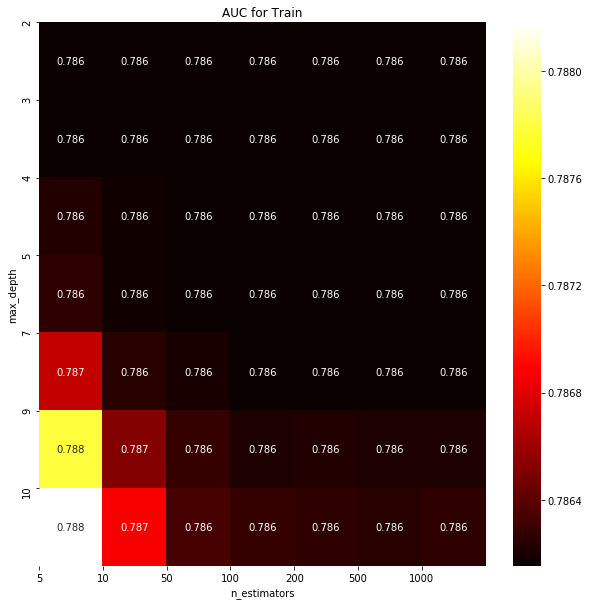

In [14]:
#https://qiita.com/bmj0114/items/8009f282c99b77780563
scores = cv_results['mean_train_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10, 10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Train')
plt.show()
    

### AUC on CV Data

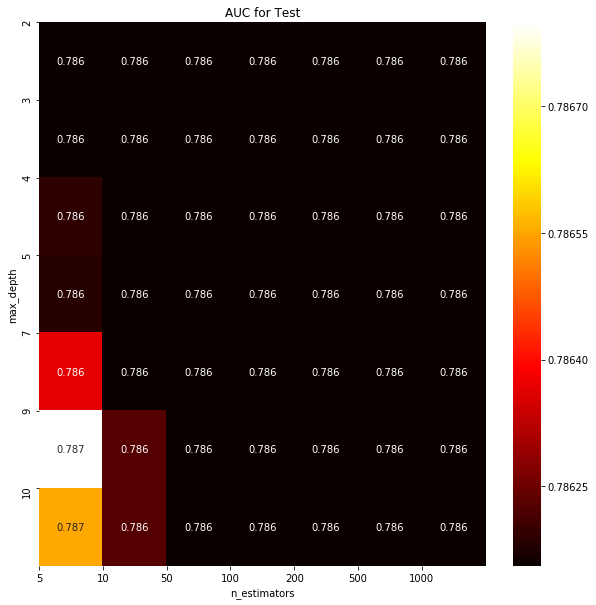

In [15]:
scores = cv_results['mean_test_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10,10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Test')
plt.show()

### Applying Hyperparameters

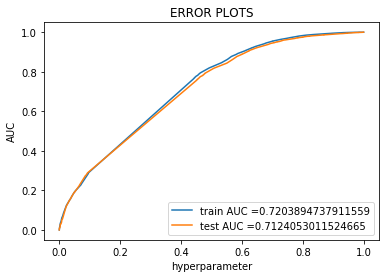

In [16]:
from sklearn.metrics import roc_curve, auc
clf = RandomForestClassifier(n_estimators=params['n_estimators'],max_depth=params['max_depth'])
clf.fit(x_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix For Train Data

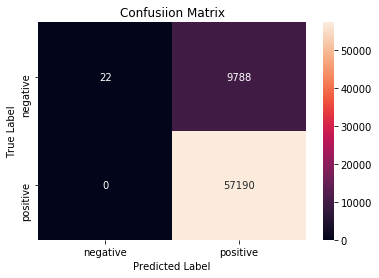

--------------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.00      0.00      9810
          1       0.85      1.00      0.92     57190

avg / total       0.88      0.85      0.79     67000



In [17]:
# predict the response
y_pred_bow = clf.predict(x_train_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('--------------------------------------------------------------')
print(classification_report(y_train ,y_pred_bow))

### Confusion Matrix on Test Data

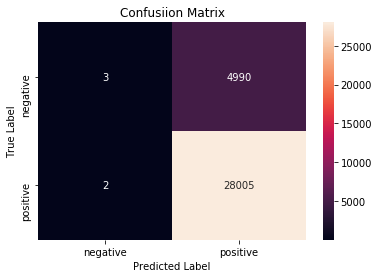

--------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.60      0.00      0.00      4993
          1       0.85      1.00      0.92     28007

avg / total       0.81      0.85      0.78     33000



In [18]:
# predict the response
y_pred_bow = clf.predict(x_test_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('--------------------------------------------------------------')
print(classification_report(y_test ,y_pred_bow))

### Top 20 most important features

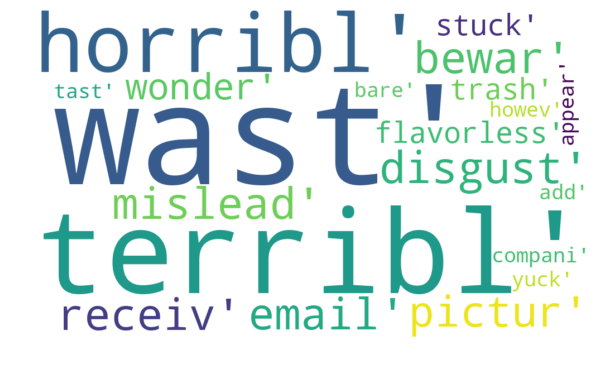

In [19]:
from wordcloud import WordCloud
important_features = clf.feature_importances_.argsort()[::-1][:20]
features = np.take(count_vect.get_feature_names(),important_features)
wordcloud = WordCloud(width=1000, height=600,background_color="white").generate(str(features))

# Display the generated image:
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## XGBOOST

In [20]:
classifier = XGBClassifier(max_features = 'sqrt')
params,cv_results,n_estimators,max_depth = optimal_val(classifier,x=x_train_bow,y=y_train)

Best tunned parameter is {'max_depth': 9, 'n_estimators': 1000}
Train data accuracy is 91.049687% 


### AUC on Train Data

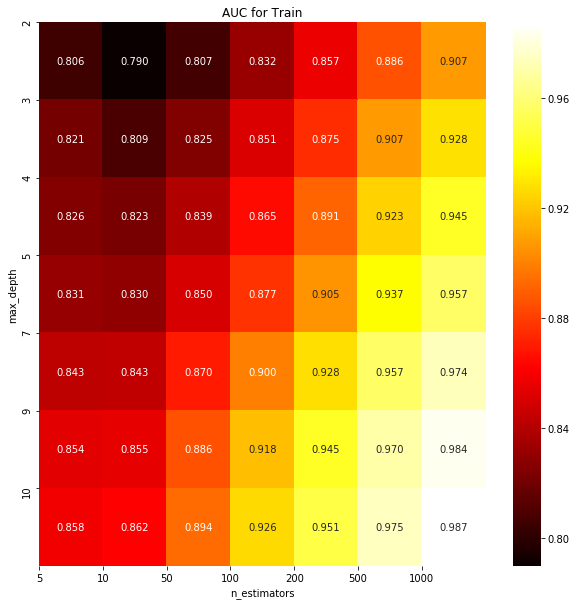

In [21]:
#https://qiita.com/bmj0114/items/8009f282c99b77780563
scores = cv_results['mean_train_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10, 10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Train')
plt.show()

### AUC on CV Data

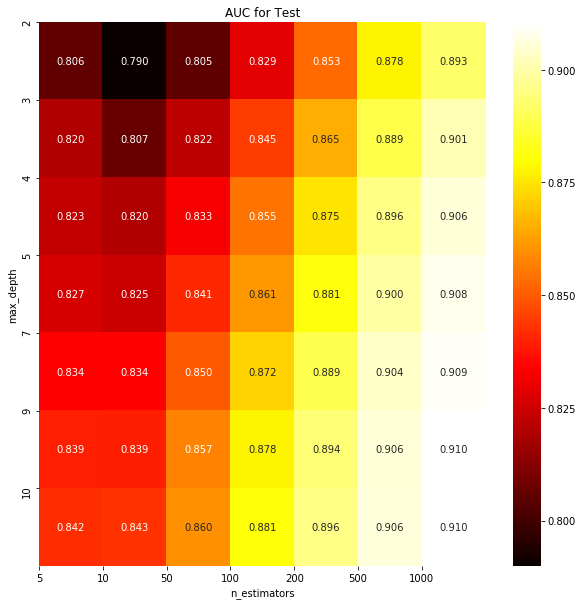

In [22]:
scores = cv_results['mean_test_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10,10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Test')
plt.show()

### Applying Hyperparameters

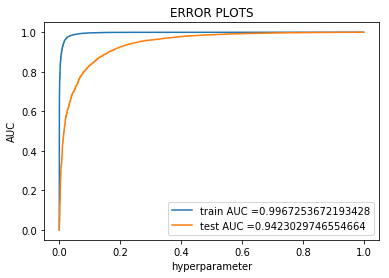

In [23]:
from sklearn.metrics import roc_curve, auc
clf = XGBClassifier(n_estimators=1000,max_depth=9)
clf.fit(x_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train Data

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


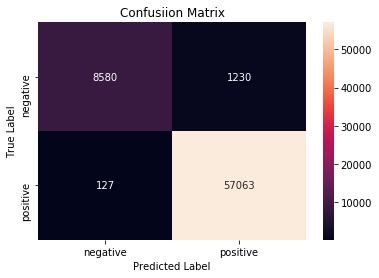

--------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.87      0.93      9810
          1       0.98      1.00      0.99     57190

avg / total       0.98      0.98      0.98     67000



In [24]:
# predict the response
y_pred_bow = clf.predict(x_train_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('--------------------------------------------------------------')
print(classification_report(y_train ,y_pred_bow))

### Confusion Matrix on Test Data

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


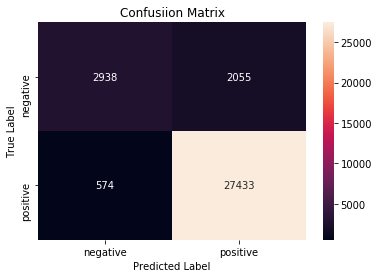

--------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.84      0.59      0.69      4993
          1       0.93      0.98      0.95     28007

avg / total       0.92      0.92      0.91     33000



In [25]:
# predict the response
y_pred_bow = clf.predict(x_test_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('--------------------------------------------------------------')
print(classification_report(y_test ,y_pred_bow))

### Top 20 most important features

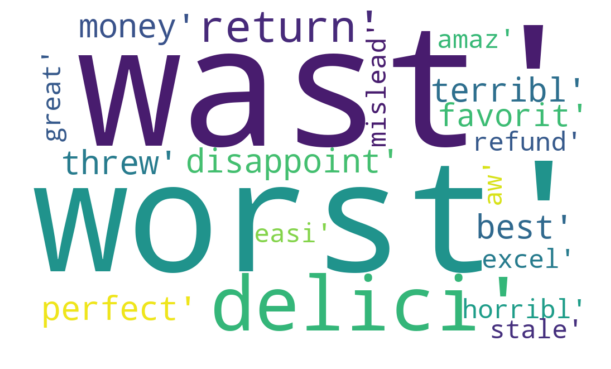

In [26]:
from wordcloud import WordCloud
important_features = clf.feature_importances_.argsort()[::-1][:20]
features = np.take(count_vect.get_feature_names(),important_features)
wordcloud = WordCloud(width=1000, height=600,background_color="white").generate(str(features))

# Display the generated image:
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Feature Engineering ON BOW 

In [27]:
#adding a column i.e Count of words in a review text to check if the performance of model increases or not
import copy as cp
x_train_fe = cp.deepcopy(x_train[0:10000])
y_train_fe = cp.deepcopy(y_train[0:10000])
x_test_fe = cp.deepcopy(x_test[0:10000])
y_test_fe = cp.deepcopy(y_test[0:10000])
count_train_words=[] 
for i in x_train_fe: 
    a=[] 
    a.append(len(i.split())) 
    count_train_words.append(a)
count_test_words=[] 
for i in x_test_fe: 
    a=[] 
    a.append(len(i.split())) 
    count_test_words.append(a) 
    
count_vect = CountVectorizer()

x_train_bow_fe = count_vect.fit_transform(x_train_fe)
x_test_bow_fe = count_vect.transform(x_test_fe) 
x_train_bow_fe = x_train_bow_fe.todense() 
x_test_bow_fe = x_test_bow_fe.todense() 
x_train_bow_fe=np.hstack((x_train_bow_fe,count_train_words)) 
x_test_bow_fe=np.hstack((x_test_bow_fe,count_test_words)) 

In [28]:
from sklearn.preprocessing import StandardScaler
import warnings as wr
wr.filterwarnings('ignore')
x_train_bow_stand_fe = StandardScaler(with_mean = False).fit_transform(x_train_bow_fe)
x_test_bow_stand_fe = StandardScaler(with_mean = False).fit_transform(x_test_bow_fe)

## Random Forest

In [29]:
classifier = RandomForestClassifier(max_features = 'sqrt')
params,cv_results,n_estimators,max_depth = optimal_val(classifier,x=x_train_bow_stand_fe,y=y_train_fe)

Best tunned parameter is {'max_depth': 10, 'n_estimators': 5}
Train data accuracy is 79.722875% 


###  AUC on Train Data

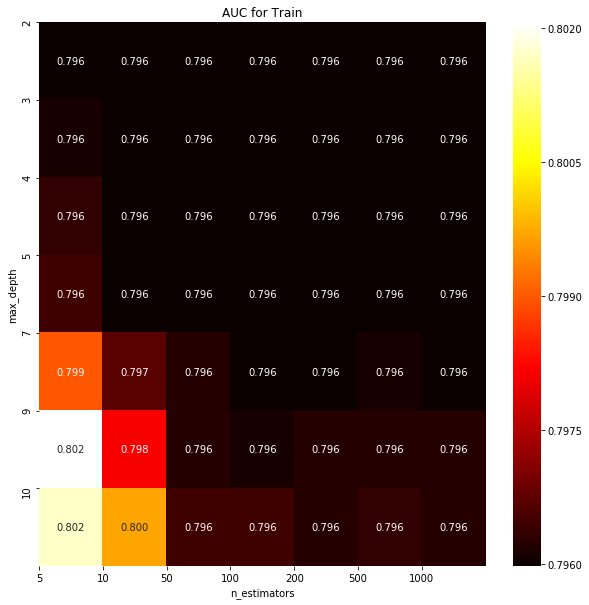

In [30]:
#https://qiita.com/bmj0114/items/8009f282c99b77780563
scores = cv_results['mean_train_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10, 10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Train')
plt.show()

### AUC on Test Data

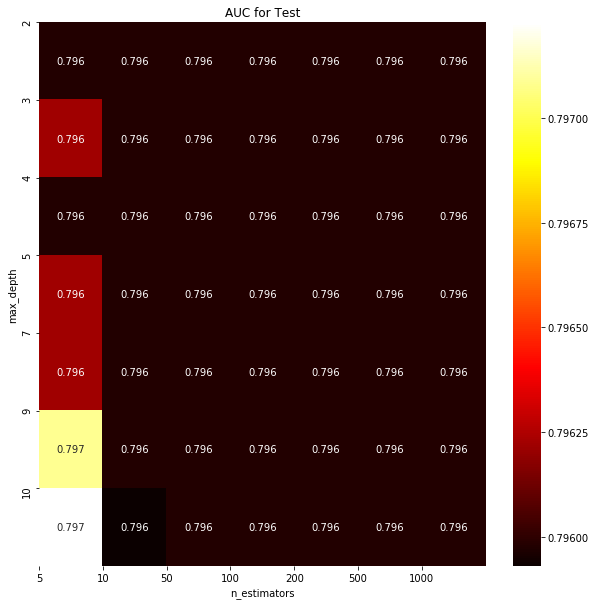

In [31]:
scores = cv_results['mean_test_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10,10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Test')
plt.show()

### Applying Hyperparameters

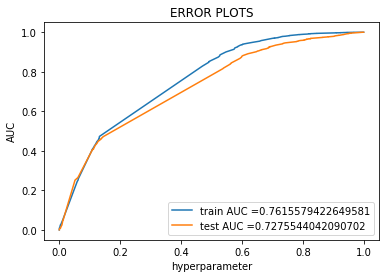

In [32]:
from sklearn.metrics import roc_curve, auc
clf = RandomForestClassifier(n_estimators=params['n_estimators'],max_depth=params['max_depth'])
clf.fit(x_train_bow_stand_fe,y_train_fe)
train_fpr, train_tpr, thresholds = roc_curve(y_train_fe, clf.predict_proba(x_train_bow_stand_fe)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_fe, clf.predict_proba(x_test_bow_stand_fe)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train Data

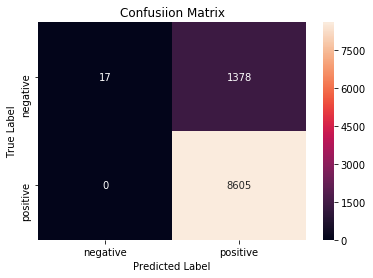

--------------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.01      0.02      1395
          1       0.86      1.00      0.93      8605

avg / total       0.88      0.86      0.80     10000



In [33]:
# predict the response
y_pred_bow = clf.predict(x_train_bow_stand_fe)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train_fe,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('--------------------------------------------------------------')
print(classification_report(y_train_fe ,y_pred_bow))

### Confusion Matrix on Test Data

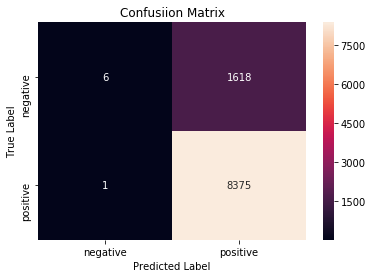

--------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.86      0.00      0.01      1624
          1       0.84      1.00      0.91      8376

avg / total       0.84      0.84      0.76     10000



In [34]:
# predict the response
y_pred_bow = clf.predict(x_test_bow_stand_fe)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test_fe,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('--------------------------------------------------------------')
print(classification_report(y_test_fe ,y_pred_bow))

### Top 20 Important Features

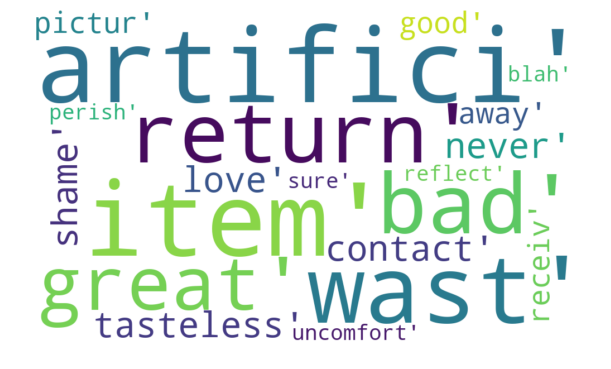

In [35]:
from wordcloud import WordCloud
important_features = clf.feature_importances_.argsort()[::-1][:20]
features = np.take(count_vect.get_feature_names(),important_features)
wordcloud = WordCloud(width=1000, height=600,background_color="white").generate(str(features))

# Display the generated image:
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Xgboost

In [36]:
classifier = XGBClassifier(max_features = 'sqrt')
params,cv_results,n_estimators,max_depth = optimal_val(classifier,x=x_train_bow,y=y_train)

Best tunned parameter is {'max_depth': 9, 'n_estimators': 1000}
Train data accuracy is 91.049687% 


### AUC on Train Data

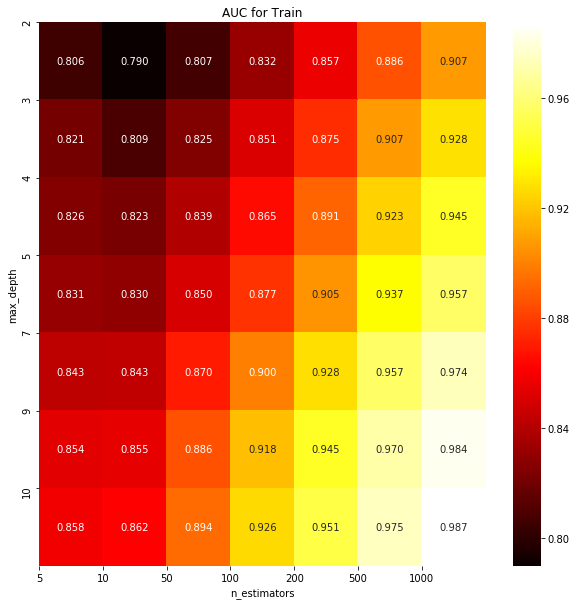

In [37]:
#https://qiita.com/bmj0114/items/8009f282c99b77780563
scores = cv_results['mean_train_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10, 10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Train')
plt.show()

### AUC on Test Data

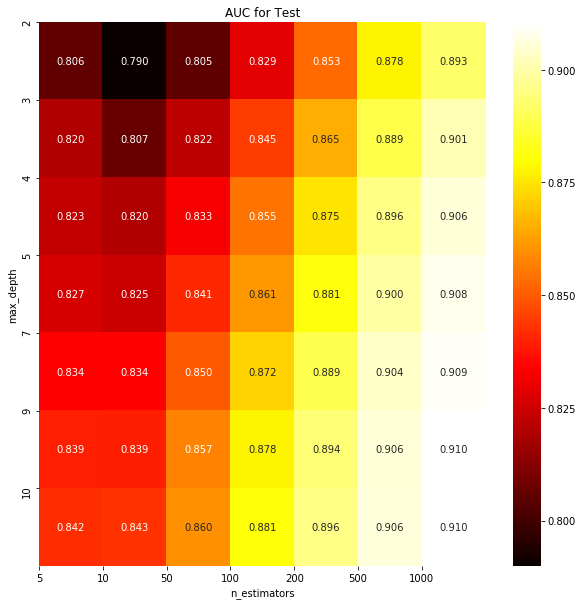

In [38]:
scores = cv_results['mean_test_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10,10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Test')
plt.show()

### Applying Hyperparameters

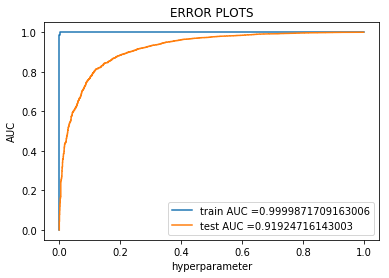

In [39]:
from sklearn.metrics import roc_curve, auc
clf = XGBClassifier(n_estimators=params['n_estimators'],max_depth=params['max_depth'])
clf.fit(x_train_bow_stand_fe,y_train_fe)
train_fpr, train_tpr, thresholds = roc_curve(y_train_fe, clf.predict_proba(x_train_bow_stand_fe)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_fe, clf.predict_proba(x_test_bow_stand_fe)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train Data

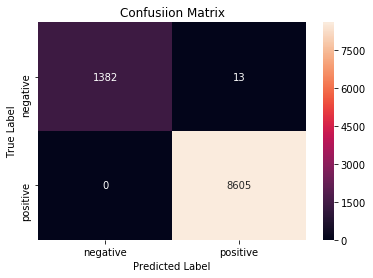

--------------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      1395
          1       1.00      1.00      1.00      8605

avg / total       1.00      1.00      1.00     10000



In [40]:
# predict the response
y_pred_bow = clf.predict(x_train_bow_stand_fe)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train_fe,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('--------------------------------------------------------------')
print(classification_report(y_train_fe ,y_pred_bow))

### Confusion Matrix on Test Data

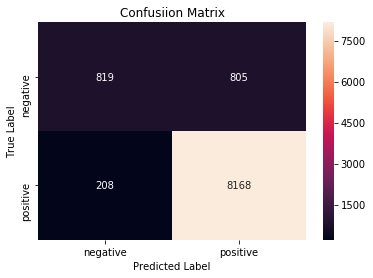

--------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.80      0.50      0.62      1624
          1       0.91      0.98      0.94      8376

avg / total       0.89      0.90      0.89     10000



In [41]:
# predict the response
y_pred_bow = clf.predict(x_test_bow_stand_fe)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test_fe,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('--------------------------------------------------------------')
print(classification_report(y_test_fe ,y_pred_bow))

### Top 20 Important Features

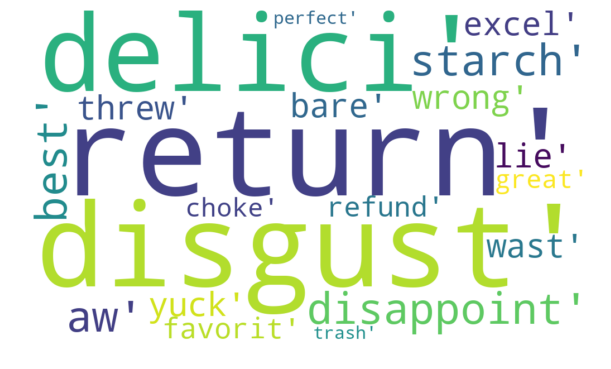

In [42]:
from wordcloud import WordCloud
important_features = clf.feature_importances_.argsort()[::-1][:20]
features = np.take(count_vect.get_feature_names(),important_features)
wordcloud = WordCloud(width=1000, height=600,background_color="white").generate(str(features))

# Display the generated image:
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
x_train_tfidf = tf_idf_vect.fit_transform(x_train)
x_test_tfidf = tf_idf_vect.transform(x_test)
print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(67000, 38973)
(33000, 38973)


## Random Forest Classifier

In [14]:
classifier = RandomForestClassifier(max_features = 'sqrt')
params,cv_results,n_estimators,max_depth = optimal_val(classifier,x=x_train_tfidf,y=y_train)

Best tunned parameter is {'max_depth': 9, 'n_estimators': 5}
Train data accuracy is 78.740294% 


### AUC on Train Data

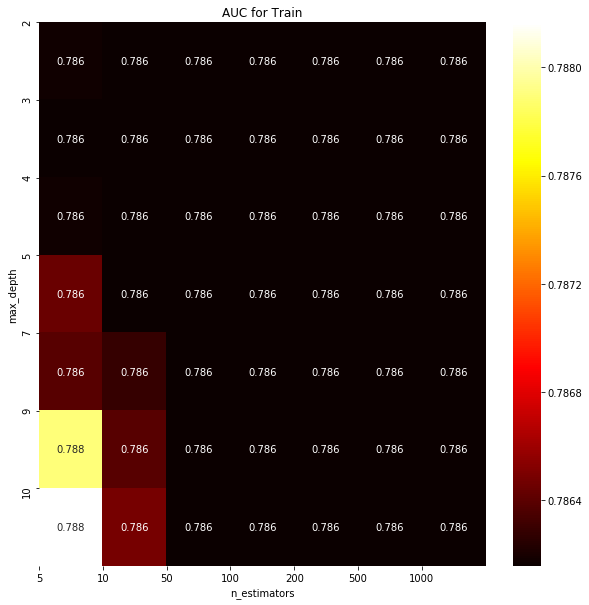

In [15]:
#https://qiita.com/bmj0114/items/8009f282c99b77780563
scores = cv_results['mean_train_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10, 10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Train')
plt.show()

### AUC on CV Data

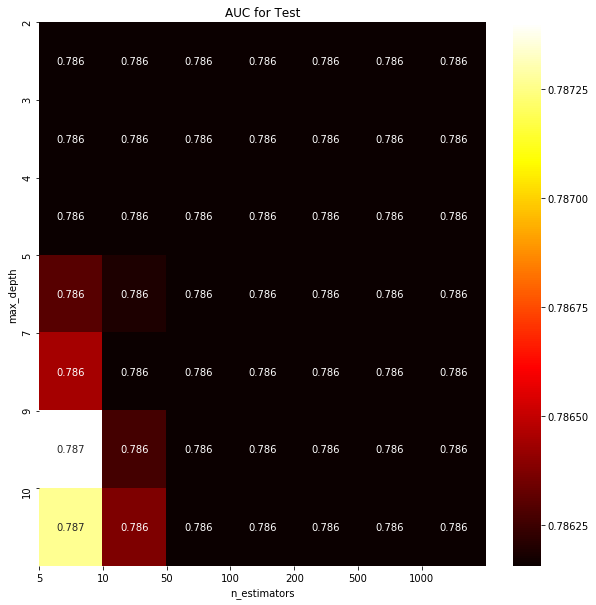

In [16]:
scores = cv_results['mean_test_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10,10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Test')
plt.show()

###  Applying best hyperparameters

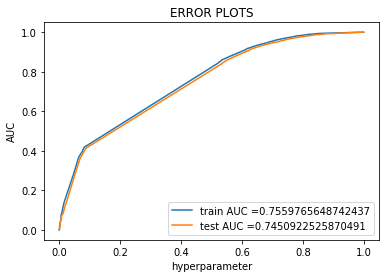

In [17]:
from sklearn.metrics import roc_curve, auc
clf = RandomForestClassifier(n_estimators=params['n_estimators'],max_depth=params['max_depth'])
clf.fit(x_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train Data

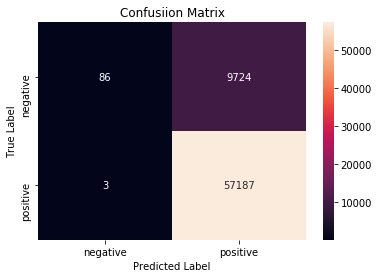

----------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.97      0.01      0.02      9810
          1       0.85      1.00      0.92     57190

avg / total       0.87      0.85      0.79     67000



In [18]:
# predict the response
y_pred_tfidf = clf.predict(x_train_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('----------------------------------------------------------------')
print(classification_report(y_train ,y_pred_tfidf))

### Confusion Matrix on Test Data

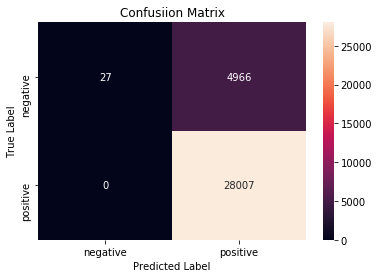

----------------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.01      0.01      4993
          1       0.85      1.00      0.92     28007

avg / total       0.87      0.85      0.78     33000



In [19]:
# predict the response
y_pred_tfidf = clf.predict(x_test_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('----------------------------------------------------------------')
print(classification_report(y_test ,y_pred_tfidf))

###  Top 20 Imprtant features

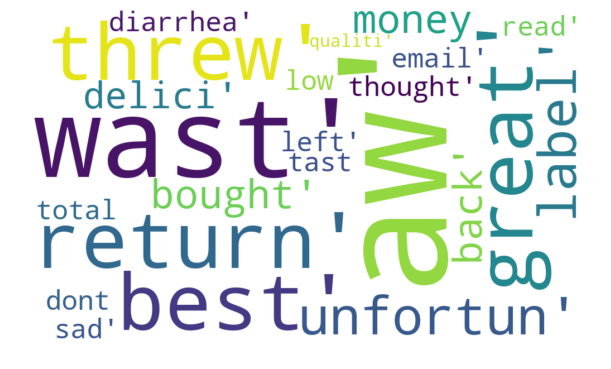

In [20]:
from wordcloud import WordCloud
important_features = clf.feature_importances_.argsort()[::-1][:20]
features = np.take(tf_idf_vect.get_feature_names(),important_features)
wordcloud = WordCloud(width=1000, height=600,background_color="white").generate(str(features))

# Display the generated image:
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Xgboost

In [23]:
classifier = XGBClassifier(max_features = 'sqrt')
params,cv_results,n_estimators,max_depth = optimal_val(classifier,x=x_train_tfidf,y=y_train)

Best tunned parameter is {'max_depth': 9, 'n_estimators': 1000}
Train data accuracy is 91.163625% 


### AUC on Train Data

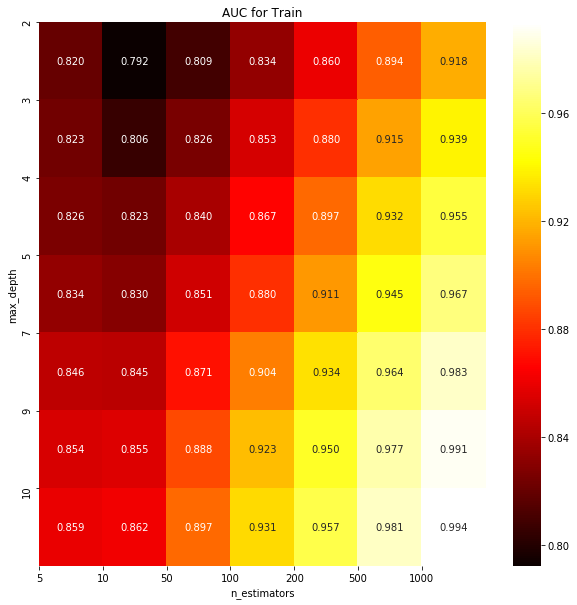

In [24]:
#https://qiita.com/bmj0114/items/8009f282c99b77780563
scores = cv_results['mean_train_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10, 10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Train')
plt.show()

### AUC on CV Data

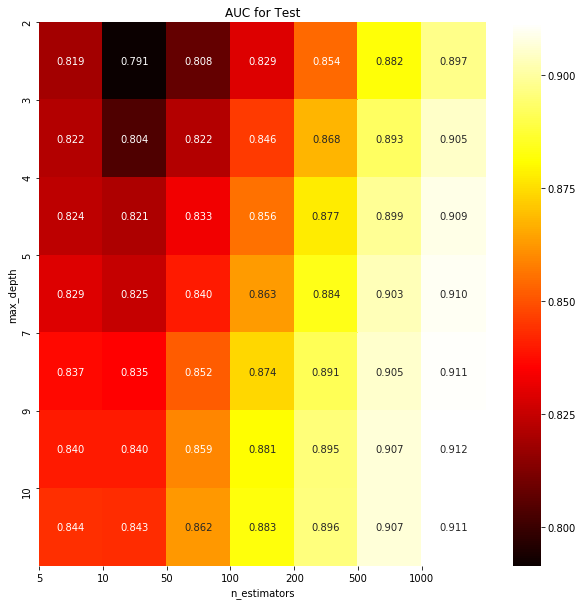

In [25]:
scores = cv_results['mean_test_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10,10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Test')
plt.show()

### Applying Hyperparameters

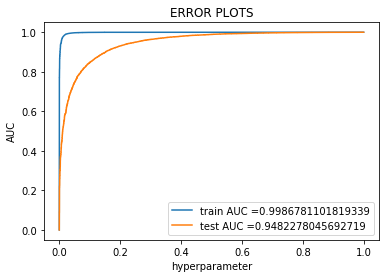

In [26]:
from sklearn.metrics import roc_curve, auc
clf = XGBClassifier(n_estimators=params['n_estimators'],max_depth=params['max_depth'])
clf.fit(x_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train Data

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


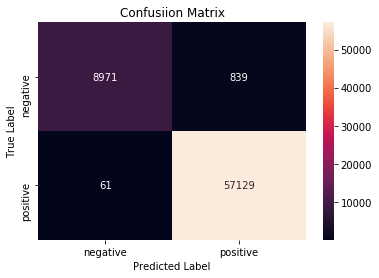

----------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      9810
          1       0.99      1.00      0.99     57190

avg / total       0.99      0.99      0.99     67000



In [27]:
# predict the response
y_pred_tfidf = clf.predict(x_train_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('----------------------------------------------------------------')
print(classification_report(y_train ,y_pred_tfidf))

### Confusion Matrix on Test Data

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


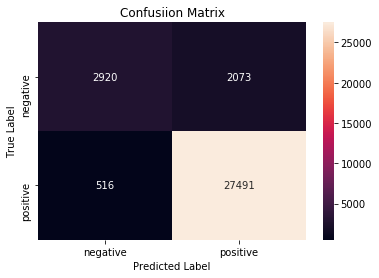

----------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.85      0.58      0.69      4993
          1       0.93      0.98      0.96     28007

avg / total       0.92      0.92      0.92     33000



In [28]:
# predict the response
y_pred_tfidf = clf.predict(x_test_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('----------------------------------------------------------------')
print(classification_report(y_test ,y_pred_tfidf))

### Top 20 most important features

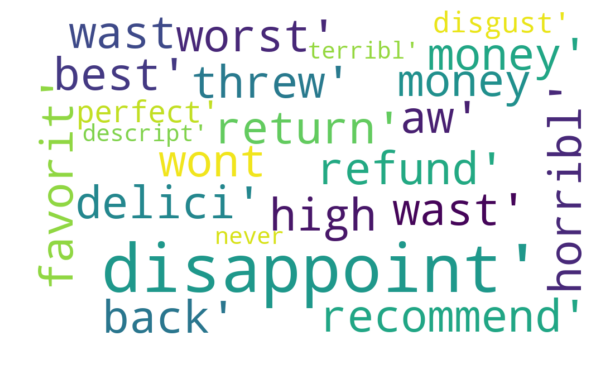

In [29]:
from wordcloud import WordCloud
important_features = clf.feature_importances_.argsort()[::-1][:20]
features = np.take(tf_idf_vect.get_feature_names(),important_features)
wordcloud = WordCloud(width=1000, height=600,background_color="white").generate(str(features))

# Display the generated image:
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Avg W2V

### Creating W2V for train data

In [30]:
#function for creating avg word2vector
from gensim.models import Word2Vec

list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

x_train_avgw2v = np.array(sent_vectors)

C:\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Using Train Model to vectorize Test data

In [31]:
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

x_test_avgw2v = np.array(sent_vectors)

In [32]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x_train_avgw2v_stand = scale.fit_transform(x_train_avgw2v)
x_test_avgw2v_stand = scale.transform(x_test_avgw2v)
print(x_train_avgw2v_stand.shape)
print(x_test_avgw2v_stand.shape)

(67000, 50)
(33000, 50)


## Random Forest Classifier

In [33]:
classifier = RandomForestClassifier(max_features = 'sqrt')
params,cv_results,n_estimators,max_depth = optimal_val(classifier,x=x_train_avgw2v_stand,y=y_train)

Best tunned parameter is {'max_depth': 10, 'n_estimators': 50}
Train data accuracy is 84.925549% 


### AUC on Train Data

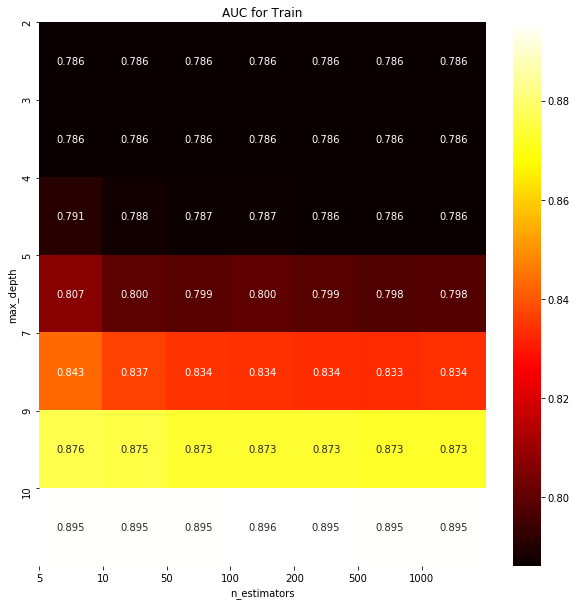

In [34]:
#https://qiita.com/bmj0114/items/8009f282c99b77780563
scores = cv_results['mean_train_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10, 10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Train')
plt.show()

### AUC on CV Data

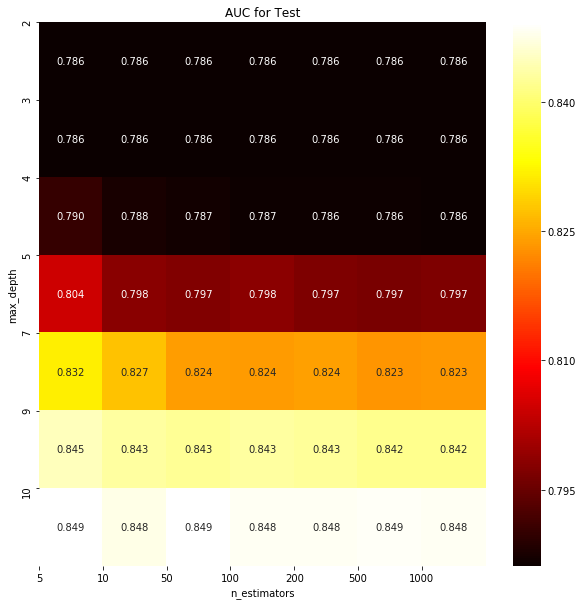

In [35]:
scores = cv_results['mean_test_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10,10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Test')
plt.show()

### Applying best hyperparameter

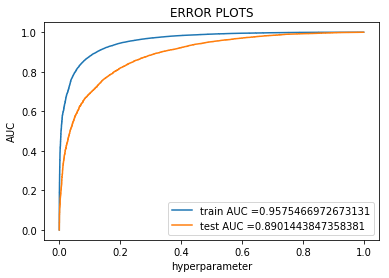

In [36]:
from sklearn.metrics import roc_curve, auc
clf = RandomForestClassifier(n_estimators=params['n_estimators'],max_depth=params['max_depth'])
clf.fit(x_train_avgw2v_stand,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_avgw2v_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_avgw2v_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix using train data

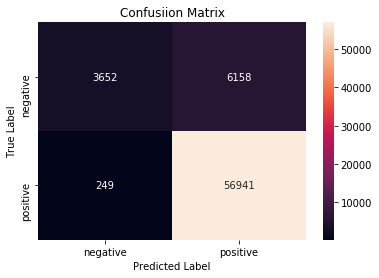

----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.94      0.37      0.53      9810
          1       0.90      1.00      0.95     57190

avg / total       0.91      0.90      0.89     67000



In [37]:
# predict the response
y_pred_w2v = clf.predict(x_train_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_w2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('----------------------------------------------------------')
print(classification_report(y_train ,y_pred_w2v))

### Confusion Matrix for test data

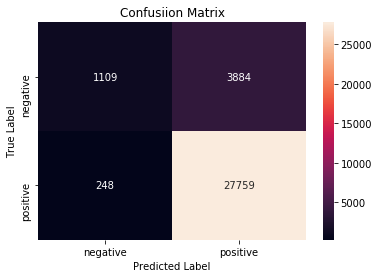

-------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.82      0.22      0.35      4993
          1       0.88      0.99      0.93     28007

avg / total       0.87      0.87      0.84     33000



In [38]:
# predict the response
y_pred_w2v = clf.predict(x_test_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_w2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-------------------------------------------------------------')
print(classification_report(y_test ,y_pred_w2v))

## Xgboost

In [39]:
classifier = XGBClassifier(max_features = 'sqrt')
params,cv_results,n_estimators,max_depth = optimal_val(classifier,x=x_train_avgw2v_stand,y=y_train)

Best tunned parameter is {'max_depth': 4, 'n_estimators': 1000}
Train data accuracy is 89.091028% 


### AUC on Train Data

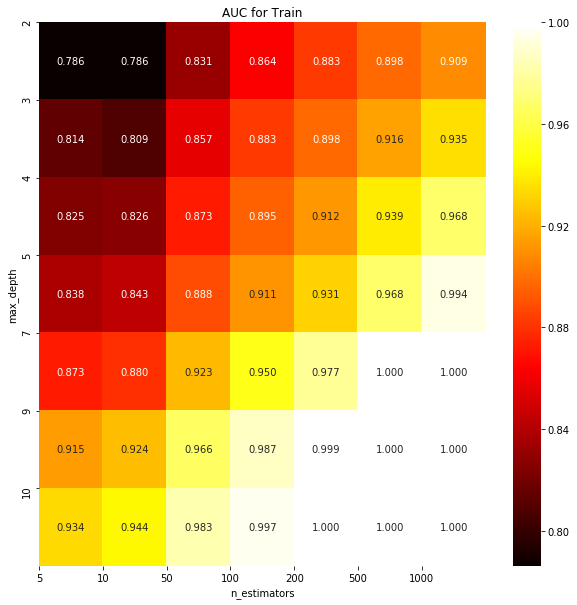

In [40]:
#https://qiita.com/bmj0114/items/8009f282c99b77780563
scores = cv_results['mean_train_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10, 10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Train')
plt.show()

### AUC on CV Data

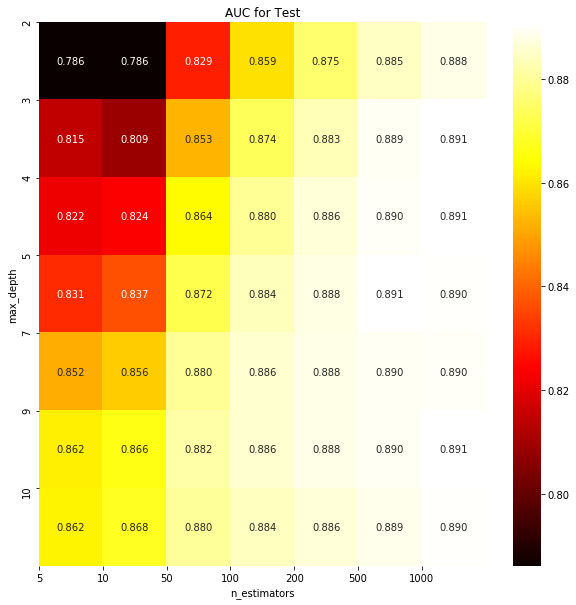

In [41]:
scores = cv_results['mean_test_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10,10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Test')
plt.show()

### Applying Hyperparameters

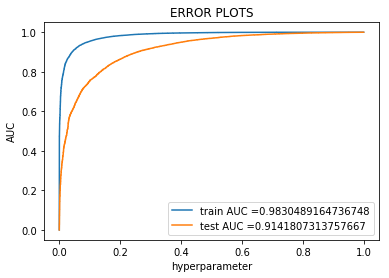

In [42]:
from sklearn.metrics import roc_curve, auc
clf = XGBClassifier(n_estimators=params['n_estimators'],max_depth=params['max_depth'])
clf.fit(x_train_avgw2v_stand,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_avgw2v_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_avgw2v_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix For Train Data

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


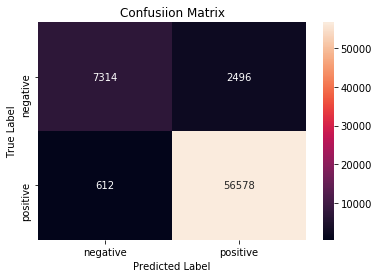

----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.92      0.75      0.82      9810
          1       0.96      0.99      0.97     57190

avg / total       0.95      0.95      0.95     67000



In [43]:
# predict the response
y_pred_w2v = clf.predict(x_train_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_w2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('----------------------------------------------------------')
print(classification_report(y_train ,y_pred_w2v))

### Confusion Matrix on Test Data

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


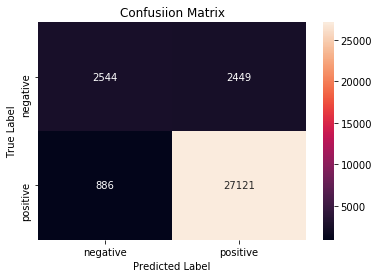

-------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.74      0.51      0.60      4993
          1       0.92      0.97      0.94     28007

avg / total       0.89      0.90      0.89     33000



In [44]:
# predict the response
y_pred_w2v = clf.predict(x_test_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_w2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-------------------------------------------------------------')
print(classification_report(y_test ,y_pred_w2v))

## TF-IDF Weighted W2V

### Creating a tf-idf weighted w2v for train data

In [45]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance: # for ea1ch review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
x_train_weighted = tfidf_sent_vectors

### Using the train model on test data

In [46]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
x_test_weighted= tfidf_sent_vectors


In [47]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x_train_weighted_stand = scale.fit_transform(x_train_weighted)
x_test_weighted_stand = scale.transform(x_test_weighted)
print(x_train_weighted_stand.shape)
print(x_test_weighted_stand.shape)

(67000, 50)
(33000, 50)


## Random Forest Classifier

In [48]:
classifier = RandomForestClassifier(max_features = 'sqrt')
params,cv_results,n_estimators,max_depth = optimal_val(classifier,x=x_train_weighted_stand,y=y_train)

Best tunned parameter is {'max_depth': 10, 'n_estimators': 5}
Train data accuracy is 83.274669% 


### AUC on Train Data

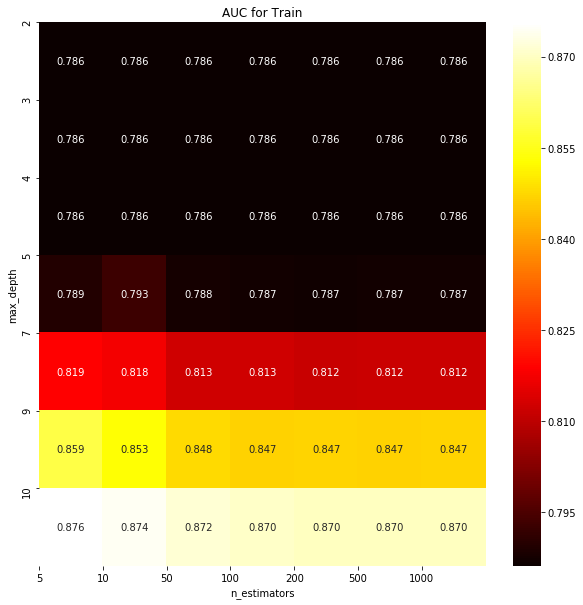

In [49]:
#https://qiita.com/bmj0114/items/8009f282c99b77780563
scores = cv_results['mean_train_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10, 10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Train')
plt.show()

### AUC on CV Data

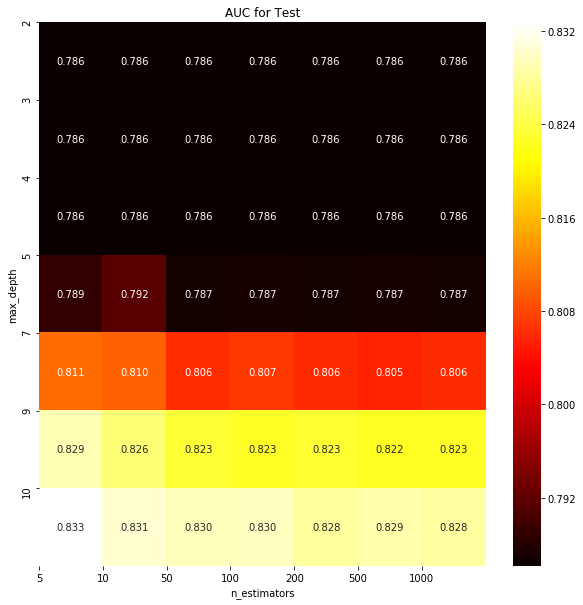

In [50]:
scores = cv_results['mean_test_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10,10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Test')
plt.show()

### Applying best hyperparameter

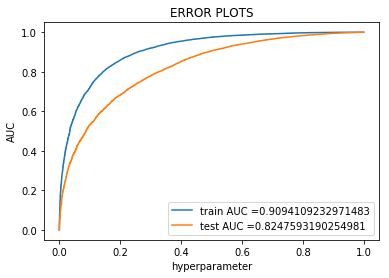

In [51]:
from sklearn.metrics import roc_curve, auc
clf = RandomForestClassifier(n_estimators=params['n_estimators'],max_depth=params['max_depth'])
clf.fit(x_train_weighted_stand,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_weighted_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_weighted_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix For Train data

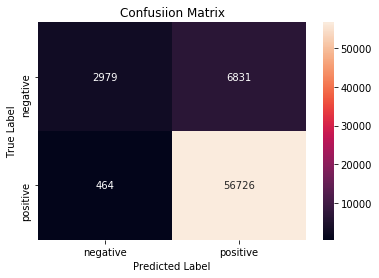

---------------------------------------------------------
             precision    recall  f1-score   support

          0       0.87      0.30      0.45      9810
          1       0.89      0.99      0.94     57190

avg / total       0.89      0.89      0.87     67000



In [52]:
# predict the response
y_pred_tfidfw2v = clf.predict(x_train_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_tfidfw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('---------------------------------------------------------')
print(classification_report(y_train ,y_pred_tfidfw2v))

### Confusion Matrix For Test data

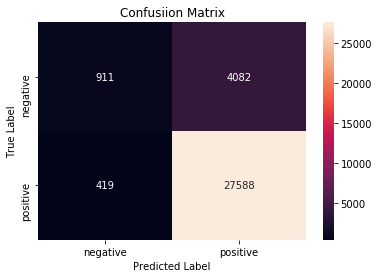

----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.68      0.18      0.29      4993
          1       0.87      0.99      0.92     28007

avg / total       0.84      0.86      0.83     33000



In [53]:
# predict the response
y_pred_tfidfw2v = clf.predict(x_test_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_tfidfw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('----------------------------------------------------------')
print(classification_report(y_test ,y_pred_tfidfw2v))

## Xgboost

In [54]:
classifier = XGBClassifier(max_features = 'sqrt')
params,cv_results,n_estimators,max_depth = optimal_val(classifier,x=x_train_weighted_stand,y=y_train)

Best tunned parameter is {'max_depth': 7, 'n_estimators': 1000}
Train data accuracy is 87.857018% 


### AUC on Train Data

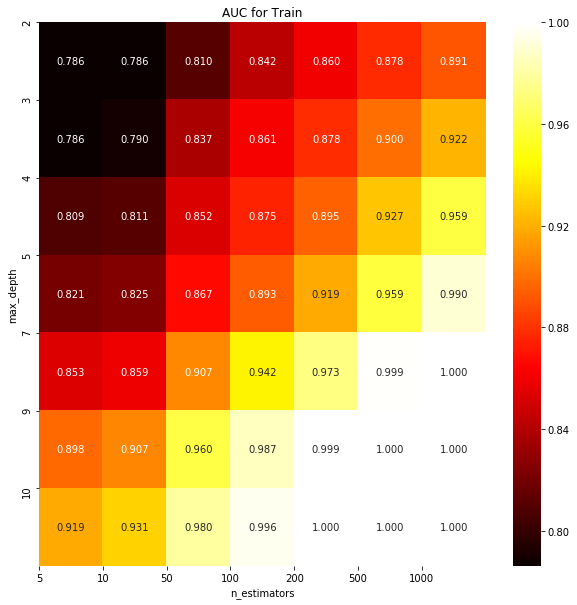

In [55]:
#https://qiita.com/bmj0114/items/8009f282c99b77780563
scores = cv_results['mean_train_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10, 10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Train')
plt.show()

### AUC on CV Data

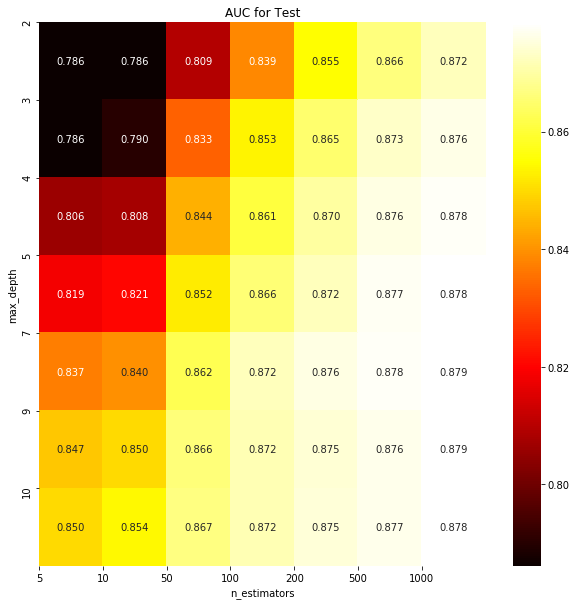

In [56]:
scores = cv_results['mean_test_score'].reshape(len(n_estimators),len(max_depth))
plt.figure(figsize=(10,10))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=n_estimators, yticklabels=max_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.title('AUC for Test')
plt.show()

### Applying Hyperparameters

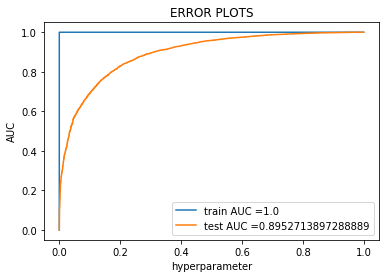

In [57]:
from sklearn.metrics import roc_curve, auc
clf = XGBClassifier(n_estimators=params['n_estimators'],max_depth=params['max_depth'])
clf.fit(x_train_weighted_stand,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_weighted_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_weighted_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix For Train Data

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


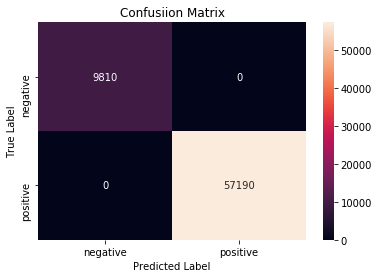

---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      9810
          1       1.00      1.00      1.00     57190

avg / total       1.00      1.00      1.00     67000



In [58]:
# predict the response
y_pred_tfidfw2v = clf.predict(x_train_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_tfidfw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('---------------------------------------------------------')
print(classification_report(y_train ,y_pred_tfidfw2v))

### Confusion Matrix on Test Data

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


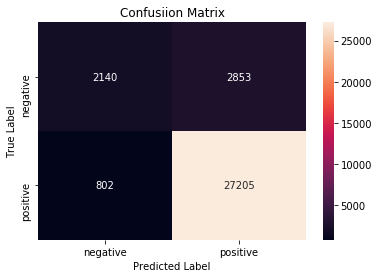

----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.73      0.43      0.54      4993
          1       0.91      0.97      0.94     28007

avg / total       0.88      0.89      0.88     33000



In [59]:
# predict the response
y_pred_tfidfw2v = clf.predict(x_test_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_tfidfw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('----------------------------------------------------------')
print(classification_report(y_test ,y_pred_tfidfw2v))

## Conclusion

In [2]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer ", "Model", "max_depth","n_estimators",'Train AUC','Test AUC']
x.add_row(["BOW", "Random Forest", 9,5,72.03,71.24])
x.add_row(["BOW", "XGBOOST", 9,1000,99.6,94.2])
x.add_row(["BOW(FE)","RandomForest",10,5,76.15,72.75])
x.add_row(["BOW(FE)","XGBOOST",9,1000,99.9,91.92])
x.add_row(["TF-IDF", "Random Forest",9,5,75.5,74.5])
x.add_row(["TF-IDF", "XGBOOST",9,1000,99.8,94.8])
x.add_row(["AVG W2V", "Random Forest",10,50,95.7,89.01])
x.add_row(["AVG W2V", "XGBOOST",4,1000,98.3,91.4])
x.add_row(["TF-IDF Weighted W2V", "Random Forest",10,5,90.9,82.4 ])
x.add_row(["TF-IDF Weighted W2V", "XGBOOST",7,1000,1,89.5 ])
print(x)

+---------------------+---------------+-----------+--------------+-----------+----------+
|     Vectorizer      |     Model     | max_depth | n_estimators | Train AUC | Test AUC |
+---------------------+---------------+-----------+--------------+-----------+----------+
|         BOW         | Random Forest |     9     |      5       |   72.03   |  71.24   |
|         BOW         |    XGBOOST    |     9     |     1000     |    99.6   |   94.2   |
|       BOW(FE)       |  RandomForest |     10    |      5       |   76.15   |  72.75   |
|       BOW(FE)       |    XGBOOST    |     9     |     1000     |    99.9   |  91.92   |
|        TF-IDF       | Random Forest |     9     |      5       |    75.5   |   74.5   |
|        TF-IDF       |    XGBOOST    |     9     |     1000     |    99.8   |   94.8   |
|       AVG W2V       | Random Forest |     10    |      50      |    95.7   |  89.01   |
|       AVG W2V       |    XGBOOST    |     4     |     1000     |    98.3   |   91.4   |
| TF-IDF W

 ## Observation

1. From the confusion matrix of BOW and TF-IDF we can clearly see that random forest is underfitting while
   xgboost is giving fitting normaly.
2. After applying Feature engineering on BOW there is no significant change in results though the test AUC is slightly decreased    in XGBOOST model
3. Xgboost is giving better accuracy for all vetorizer in comparision to random forest.
4. xgboost has taken higher n_estimators for all vectorizers than random forest.